In [1]:
import torch
import utils
import numpy as np
from torch import nn
from trainer import train
from torch.utils import data
from concreteNet import ConcreteAutoencoder
%matplotlib inline

/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../../data/filtered_gene_bc_matrices/hg19"
device = utils.get_device()
#device = torch.device("cpu")
device

device(type='cuda', index=1)

In [3]:
adata = utils.anndata_load(file_path)
adata = utils.anndata_preprocess(adata)
adata.shape

(2700, 4758)

In [4]:
def get_net(input_dim, k, hidden_dim,device):
    return ConcreteAutoencoder(input_dim, k,hidden_dim,device)
def load_adata(adata, batch_size):
    return utils.data_loader(adata, batch_size)

In [15]:
num_epoch, learning_rate, weight_dacay, batch_size = 256, 0.05, 0, 256
input_dim = adata.n_vars
init_temp = 10
end_temp = 0.01
loss = nn.MSELoss()
net = get_net(input_dim=input_dim, k=1000, hidden_dim=128,
              device=device)
dataloader = load_adata(adata=adata, batch_size=batch_size)


In [16]:
train(net=net, loss=loss, dataloader=dataloader,
      num_epoch=num_epoch, learning_rate=learning_rate,
      weight_decay=weight_dacay, device=device, init_temp=init_temp, 
      end_temp= end_temp)

Epoch: 1 ; Loss: 12.90655; Temperature: 9.822; Time: 2.16 s
Epoch: 2 ; Loss: 0.79795; Temperature: 9.647; Time: 3.84 s
Epoch: 3 ; Loss: 0.68962; Temperature: 9.475; Time: 5.89 s
Epoch: 4 ; Loss: 0.57981; Temperature: 9.306; Time: 7.26 s
Epoch: 5 ; Loss: 0.49762; Temperature: 9.140; Time: 8.92 s
Epoch: 6 ; Loss: 0.44392; Temperature: 8.977; Time: 10.81 s
Epoch: 7 ; Loss: 0.41130; Temperature: 8.817; Time: 12.91 s
Epoch: 8 ; Loss: 0.39194; Temperature: 8.660; Time: 15.18 s
Epoch: 9 ; Loss: 0.38104; Temperature: 8.505; Time: 17.35 s
Epoch: 10 ; Loss: 0.37433; Temperature: 8.354; Time: 19.51 s
Epoch: 11 ; Loss: 0.36995; Temperature: 8.205; Time: 21.73 s
Epoch: 12 ; Loss: 0.36817; Temperature: 8.058; Time: 23.74 s
Epoch: 13 ; Loss: 0.36663; Temperature: 7.915; Time: 24.91 s
Epoch: 14 ; Loss: 0.36574; Temperature: 7.774; Time: 25.93 s
Epoch: 15 ; Loss: 0.36533; Temperature: 7.635; Time: 26.99 s
Epoch: 16 ; Loss: 0.36528; Temperature: 7.499; Time: 27.95 s
Epoch: 17 ; Loss: 0.36452; Temperatur

In [17]:
x_val = torch.Tensor(adata.X.A).to(device) # type: ignore
_, z, m = net(x_val, temperature = end_temp)
z.shape

torch.Size([2700, 1000])

In [18]:
z = z.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()

In [19]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [20]:
res_adata = ad.AnnData(z)

In [21]:
sc.tl.pca(res_adata, svd_solver='arpack')


/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


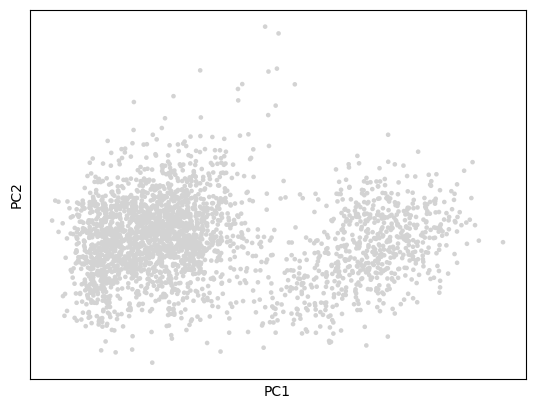

In [22]:
sc.pl.pca(res_adata)

In [23]:
sc.pp.neighbors(res_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(res_adata)
sc.tl.leiden(res_adata)

/home/qinxianhan/.conda/envs/singleCell/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


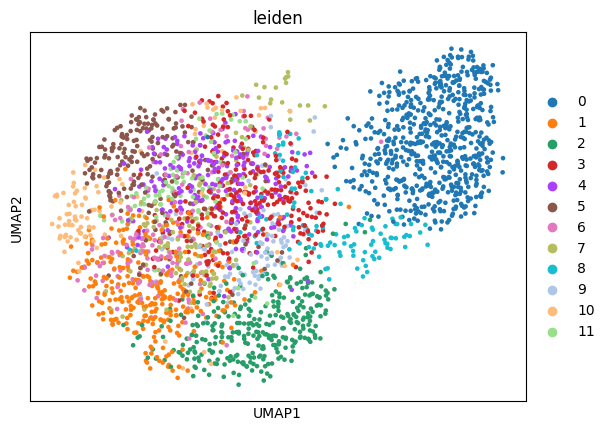

In [24]:
sc.pl.umap(res_adata, color='leiden')

In [ ]:
max_idx = []
for i in range(m.shape[1]):
    max_idx.append(np.argmax(m[:,i]))
max_idx

In [ ]:
for i in range(m.shape[1]):
    print(max(m[:,i]))

In [ ]:
def find_same(index):
    count = 0
    for i in range(1,len(index)):
        for j in range(i):
            if index[j] == index[i]:
                count +=1
    print(count)  

In [ ]:
find_same(max_idx)

In [ ]:
res_genes = adata.var_names[max_idx]

In [ ]:
res_adata.var_names = res_genes # type: ignore

In [ ]:
sc.tl.rank_genes_groups(res_adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(res_adata, n_genes=25, sharey=False)

In [ ]:
adata = utils.anndata_load(file_path=file_path)
adata = utils.anndata_preprocess(adata=adata,n_top_genes=1000)

In [ ]:
var_genes = adata.var_names

In [ ]:
res_adata.var_names_make_unique()

In [ ]:
s = set(res_adata.var_names)

In [ ]:
temp1 = [x for x in var_genes if x not in s]

In [ ]:
len(temp1)

In [ ]:
temp2 = [x for x in s if x not in var_genes]

In [ ]:
len(temp2)

In [ ]:
temp1

In [ ]:
temp2